Enter the commodity name (e.g., Apple, Banana, Tomato): Cucumber(Local)


D:\Anaconda Navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - loss: 0.0281 - val_loss: 0.0078
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0083 - val_loss: 0.0061
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - los

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


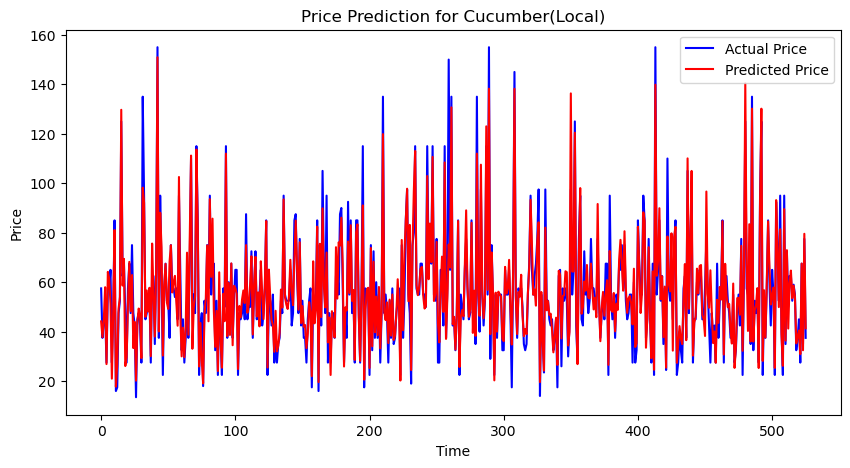

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted price for Cucumber(Local): ₹41.37


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load the dataset (replace 'your_data.csv' with your dataset file)
data = pd.read_csv('Final.csv')

# Ensure to parse dates correctly
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

# Function to scale and prepare the data for LSTM
def prepare_data(data, commodity_name, time_step=60):
    commodity_data = data[data['Commodity'] == commodity_name]

    # Check if the commodity exists in the dataset
    if commodity_data.empty:
        raise ValueError(f"The commodity '{commodity_name}' was not found in the dataset.")

    # Use average prices as the target variable
    features = commodity_data[['Average']].copy()  # Using 'Average' price, adjust if needed
    features['Temperature'] = np.random.rand(len(features)) * 30  # Placeholder for temperature
    features['Rainfall'] = np.random.rand(len(features)) * 100  # Placeholder for rainfall

    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(features)

    X, y = [], []
    for i in range(len(scaled_data) - time_step):
        X.append(scaled_data[i:i + time_step, :])  # past `time_step` values as features
        y.append(scaled_data[i + time_step, 0])    # next value of 'Average' as target
    return np.array(X), np.array(y), scaler

# Get user input for the commodity
commodity_name = input("Enter the commodity name (e.g., Apple, Banana, Tomato): ")

try:
    X, y, scaler = prepare_data(data, commodity_name)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Save the model in HDF5 format after training
    model.save('commodity_price_prediction_model.h5')  # Save the trained model

    # Make predictions
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], 2))), axis=1))[:, 0]
    y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))), axis=1))[:, 0]

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, color='blue', label='Actual Price')
    plt.plot(predicted_prices, color='red', label='Predicted Price')
    plt.title(f'Price Prediction for {commodity_name}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Show prediction for the last input sample
    last_input = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])
    last_prediction = model.predict(last_input)
    last_prediction_price = scaler.inverse_transform(np.concatenate((last_prediction, np.zeros((last_prediction.shape[0], 2))), axis=1))[:, 0]
    print(f"Predicted price for {commodity_name}: ₹{last_prediction_price[0]:.2f}")

except ValueError as e:
    print(e)
